# Tesla Stock Predictions Inference



In [2]:
import pandas as pd

data = pd.read_csv("TSLA-2014-12-27-2019-12-27.csv")

# Let us see what our data looks like
print(data.head())
print(data.describe())

         Date        Open        High         Low       Close   Adj Close  \
0  2014-12-29  226.899994  227.910004  224.020004  225.710007  225.710007   
1  2014-12-30  223.990005  225.649994  221.399994  222.229996  222.229996   
2  2014-12-31  223.089996  225.679993  222.250000  222.410004  222.410004   
3  2015-01-02  222.869995  223.250000  213.259995  219.309998  219.309998   
4  2015-01-05  214.550003  216.500000  207.160004  210.089996  210.089996   

    Volume  
0  2802500  
1  2903200  
2  2297500  
3  4764400  
4  5368500  
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    268.464702   272.893026   263.884877   268.576069   268.576069   
std      55.760993    56.623837    54.890845    55.851123    55.851123   
min     142.320007   154.970001   141.050003   143.669998   143.669998   
25%     221.975006   225.139999   218.055001   220.895004   220.895004   
50%     257.350

### Loading the Scaler, Models and Dataset classes

In [3]:
import torch
import torch.nn as nn
import torch.utils.data.dataset as dataset
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pickle

In [5]:
scaler = pickle.load(open("saved/scaler.pkl", "rb"))

pre_normalized = data[["Open", "High", "Low", "Close"]]

normalized_data = scaler.fit_transform(pre_normalized)

In [6]:
# We need to load the models

%run lstm_model.py
%run regular_model.py

print(open("lstm_model.py", "r").read())
print(open("regular_model.py", "r").read())

import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, hidden_dim):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(4, hidden_dim, bias=True)
        self.fc1 = nn.Linear(hidden_dim, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, 4)

    def forward(self, input, hidden, cell):
        output, (hidden, cell) = self.lstm(input.view(1, 1, -1), (hidden, cell))
        output = nn.functional.relu(self.fc1(output))
        output = nn.functional.relu(self.fc2(output))
        output = self.fc3(output)
        
        return output, (hidden, cell)
    
    def init_hidden(self):
        hidden = torch.zeros(1, 1, self.hidden_dim)
        cell = torch.zeros(1, 1, self.hidden_dim)

        return (hidden, cell)

    def evaluate(self, model, test_loader, hidden, cell, loss_function):
        loss = 0
        
        for i in range(len(test_loader) - 1):
        

We need to load the datasets

In [7]:
regular_model = RegularModel()
regular_model.load_state_dict(torch.load("saved/regular_model.pkl"))
regular_model.eval()

lstm_model = LSTMModel(8)
lstm_model.load_state_dict(torch.load("saved/lstm_model.pkl"))
lstm_model.eval()

pass

### Inference

We need to prepare the data, we will use it to performance inference and hopefully we will see how good the model is.

In [8]:
train_len = int(0.9 * len(normalized_data))

train = normalized_data[:train_len]
test = normalized_data[train_len:]

Now we can run the model to see how well it would work

In [9]:
with torch.no_grad():
    regular_predicted_one_by_one = []
    lstm_predicted_one_by_one = []

    (hidden, cell) = lstm_model.init_hidden()

    for i in range(len(normalized_data)):
        if i < 1:
            pass
        else:
            arr = []
            arr.extend(normalized_data[i - 1])
            arr.extend(normalized_data[i])
            input = torch.tensor(arr, dtype=torch.float32)
            regular_output = regular_model.forward(input)

            lstm_input = torch.tensor(normalized_data[i], dtype=torch.float32)
            lstm_output, (hidden, cell) = lstm_model.forward(lstm_input, hidden, cell)

            regular_predicted_one_by_one.append(regular_output)
            lstm_predicted_one_by_one.append(lstm_output)

            
regular_predicted_one_by_one = map(lambda x: x.numpy(), regular_predicted_one_by_one)
lstm_predicted_one_by_one = map(lambda x: x.numpy()[0][0], lstm_predicted_one_by_one)



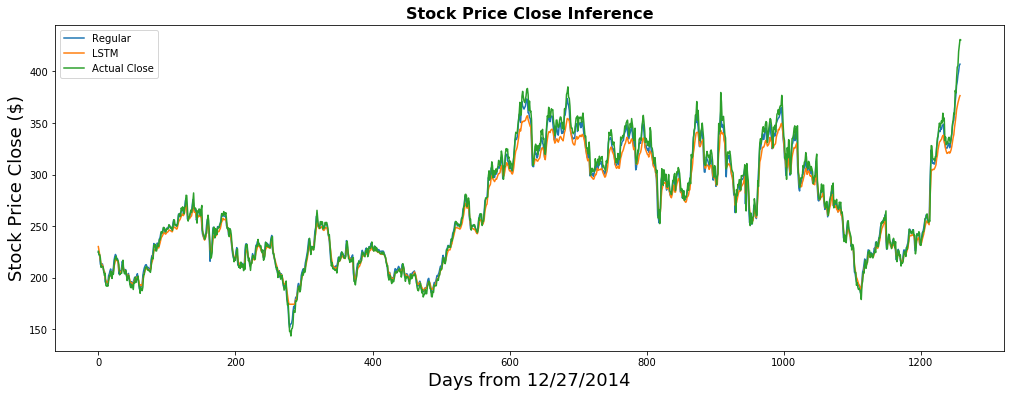

In [32]:
import matplotlib.pyplot as plt


unscaled_regular_predicted_one_by_one = scaler.inverse_transform(regular_predicted_one_by_one)
unscaled_lstm_predicted_one_by_one = scaler.inverse_transform(lstm_predicted_one_by_one)
unscaled_normalized_data = scaler.inverse_transform(normalized_data)


close_regular_predicted_one_by_one = map(lambda x: x[3], unscaled_regular_predicted_one_by_one)
close_lstm_predicted_one_by_one = map(lambda x: x[3], unscaled_lstm_predicted_one_by_one)
close_normalized_data  = map(lambda x: x[3], unscaled_normalized_data)

plt.rcParams['figure.figsize'] = [17, 6]
plt.plot(close_regular_predicted_one_by_one, label="Regular")
plt.plot(close_lstm_predicted_one_by_one, label="LSTM")
plt.plot(close_normalized_data, label="Actual Close")

plt.ylabel('Stock Price Close ($)', size = 18)
plt.xlabel('Days from 12/27/2014', size = 18)
plt.title('Stock Price Close Inference', size = 16, weight = 'bold')


plt.legend()
plt.show()